# **PCB ERROR DETECTION AND CLASSIFICATION**

---



---

## **Train Model**

---

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
import os
import random
import re
import shutil
sns.set_style('darkgrid')
sns.set_palette('pastel')
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, utils
import copy
import time
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.model_selection import train_test_split

 **DEFINING THE INPUT**

In [ ]:
input_dir='/content/drive/MyDrive/PCB_DATASET/'
os.listdir(input_dir)

['Annotations',
 'images',
 'rotate.py',
 'rotation',
 'PCB_USED',
 'images_combined',
 'patches']

**DATA PREPARATION**

In [ ]:
template_dir=os.path.join(input_dir,'PCB_USED')
template_dir

'/content/drive/MyDrive/PCB_DATASET/PCB_USED'

In [ ]:
#Defining the image directory
img_dir=os.path.join(input_dir,'images')

#Listing the types of defects
os.listdir(img_dir)
types_defect=os.listdir(os.path.join(input_dir,'images'))
types_defect

['Spur',
 'Spurious_copper',
 'Short',
 'Open_circuit',
 'Mouse_bite',
 'Missing_hole']

In [ ]:
#Creating an image path list for ready refernce
img_path_list=[]
#Creating img_path list
for sub_cat in types_defect:
    for file in os.listdir(os.path.join(img_dir,sub_cat)):
        img_path_list.append(os.path.join(img_dir,sub_cat,file))

In [ ]:
rotated_dir=os.path.join(input_dir,'rotation')
os.listdir(rotated_dir)

['Spurious_copper_angles.txt',
 'Spur_angles.txt',
 'Missing_hole_angles.txt',
 'Mouse_bite_angles.txt',
 'Open_circuit_angles.txt',
 'Short_angles.txt',
 'Spur_rotation',
 'Short_rotation',
 'Spurious_copper_rotation',
 'Open_circuit_rotation',
 'Mouse_bite_rotation',
 'Missing_hole_rotation']

In [ ]:
rotated_angle_list=[j for j in os.listdir(rotated_dir) if j.endswith('.txt')]
rotated_angle_list

['Spurious_copper_angles.txt',
 'Spur_angles.txt',
 'Missing_hole_angles.txt',
 'Mouse_bite_angles.txt',
 'Open_circuit_angles.txt',
 'Short_angles.txt']

In [ ]:
types_defect_rotated=[j for j in os.listdir(rotated_dir) if j.endswith('.txt')==False]
types_defect_rotated

['Spur_rotation',
 'Short_rotation',
 'Spurious_copper_rotation',
 'Open_circuit_rotation',
 'Mouse_bite_rotation',
 'Missing_hole_rotation']

In [ ]:
annote_dir=os.path.join(input_dir,'Annotations')
annote_dir

'/content/drive/MyDrive/PCB_DATASET/Annotations'

In [ ]:
type_annot=os.listdir(annote_dir)
type_annot

['Short',
 'Missing_hole',
 'Spur',
 'Spurious_copper',
 'Open_circuit',
 'Mouse_bite']

In [ ]:
#Checking the type of files
file_list=os.listdir(os.path.join(annote_dir,'Mouse_bite'))
file_list[0:5]

['07_mouse_bite_07.xml',
 '11_mouse_bite_05.xml',
 '12_mouse_bite_02.xml',
 '07_mouse_bite_06.xml',
 '08_mouse_bite_10.xml']

In [ ]:
import xml.etree.ElementTree as ET

In [ ]:
#Parsing XML to return Bounding box dimensions
def parse_xml(xml_file):

    data=[]

    tree = ET.parse(xml_file)
    root = tree.getroot()

    filename = root.find('filename').text
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)
    for obj in root.findall('object'):
        name = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        data.append({
            'filename': filename,
            'width': width,
            'height': height,
            'class': name,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })

    return data

In [ ]:
#Retrieving data for all files
data=[]
all_data=[]

for x in type_annot:
    for file in os.listdir(os.path.join(annote_dir,x)):
        xml_file_path=os.path.join(os.path.join(annote_dir,x),file)
        data=parse_xml(xml_file_path)
        all_data.extend(data)

In [ ]:
#Creating a dataframe to store the annotations
df_annot=pd.DataFrame(all_data)
df_annot

filename  width  height       class  xmin  ymin  xmax  ymax
0          11_short_02.jpg   2282    2248       short  1024  1113  1098  1201
1          11_short_02.jpg   2282    2248       short  1694  1632  1768  1740
2          11_short_02.jpg   2282    2248       short  1666  1973  1732  2060
3          11_short_02.jpg   2282    2248       short   604  1662   714  1755
4          11_short_02.jpg   2282    2248       short   430  1401   573  1501
...                    ...    ...     ...         ...   ...   ...   ...   ...
2948  05_mouse_bite_09.jpg   2544    2156  mouse_bite   981   567  1052   612
2949  05_mouse_bite_09.jpg   2544    2156  mouse_bite  1525   579  1588   621
2950  05_mouse_bite_09.jpg   2544    2156  mouse_bite  1624  1013  1675  1068
2951  05_mouse_bite_09.jpg   2544    2156  mouse_bite  1605  1467  1650  1509
2952  05_mouse_bite_09.jpg   2544    2156  mouse_bite  1542  1663  1601  1710

[2953 rows x 8 columns]

Text(0.5, 0, 'No of defects in one PCB')

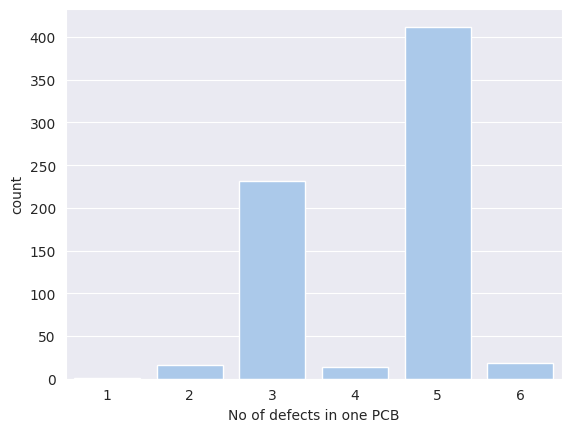

In [ ]:
#Visualizing the no of defects in each pcb
df_multiple_defects=pd.DataFrame(df_annot['filename'].value_counts())
sns.countplot(df_multiple_defects,x='count')
plt.xlabel('No of defects in one PCB')

In [ ]:
#Getting filename from filepath
filepath=img_path_list[0]
filename=re.sub(r'.+/([\w_]+\.jpg)',r'\1',filepath)

In [ ]:
#Defining a function to view image along with bounding box

def draw_bounding_boxes(image_path, bounding_boxes,annotation):
    """
    Draws multiple bounding boxes on an image using Matplotlib.

    Args:
        image_path: The path to the image file.
        bounding_boxes: A list of bounding boxes, each represented as a tuple or list containing
                       (min_x, min_y, max_x, max_y).
    """

    # Load the image
    img = plt.imread(image_path)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(15,10))

    # Display the image
    ax.imshow(img)

    # Draw each bounding box
    for bbox in bounding_boxes:
        min_x, min_y, max_x, max_y = bbox
        width = max_x - min_x
        height = max_y - min_y
        rect = patches.Rectangle((min_x, min_y), width, height, linewidth=1, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        # Calculate the centroid of the bounding box
        centroid_x = (min_x + max_x) / 2
        centroid_y = (min_y + max_y) / 2

        # Add the annotation to the centroid
        ax.annotate( annotation,(centroid_x,centroid_y),(max_x+20,max_y+20),
            fontsize=10,color='white',
            horizontalalignment='right', verticalalignment='top')

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])



    # Show the plot
    plt.show()

In [ ]:
#Defining function to select the a file and return image along with bounding box
def visualize_annotations(list_image_path,df):
    for i in list_image_path:
        filepath=i
        filename=re.sub(r'.+/([\w_]+\.jpg)',r'\1',filepath)
        df_selected=df[df['filename']==filename]
        width=df_selected['width'].values
        height=df_selected['height'].values
        class_name=df_selected['class'].values
        xmin=df_selected['xmin'].values
        ymin=df_selected['ymin'].values
        xmax=df_selected['xmax'].values
        ymax=df_selected['ymax'].values

        bbox=zip(xmin,ymin,xmax,ymax)
        draw_bounding_boxes(filepath, bbox,class_name[0])

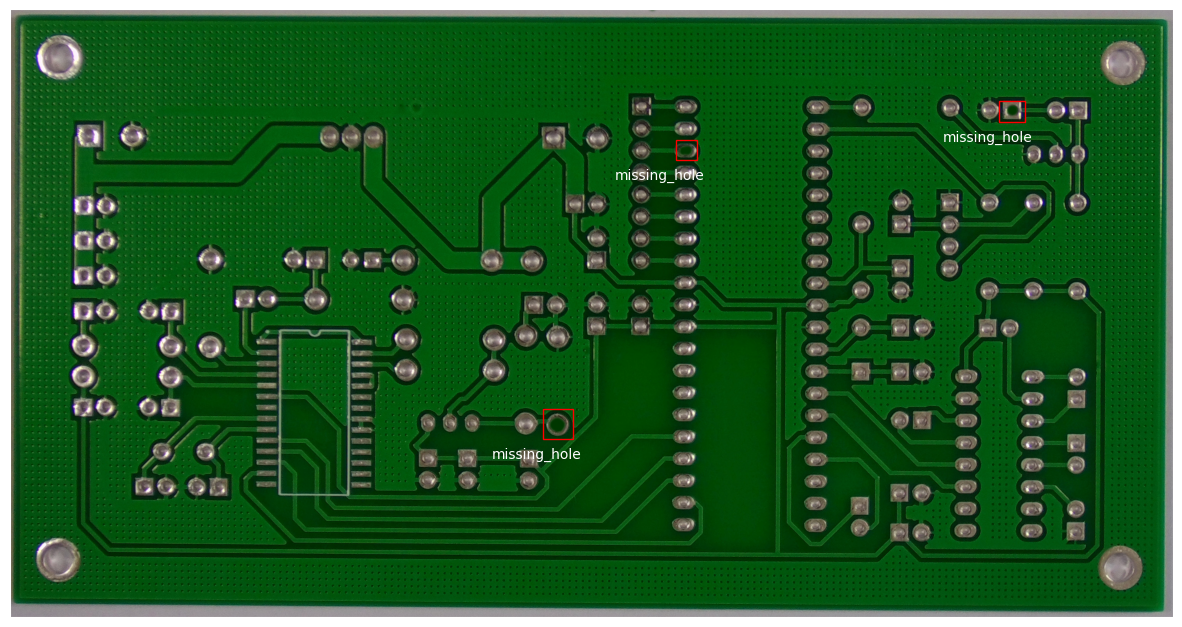

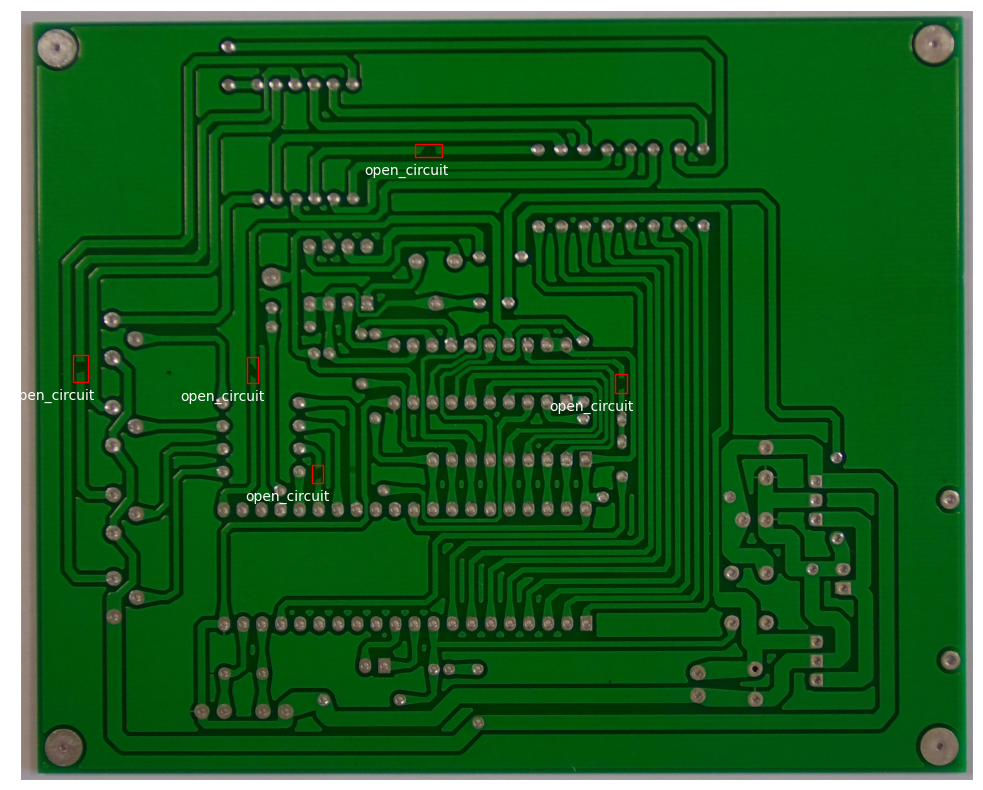

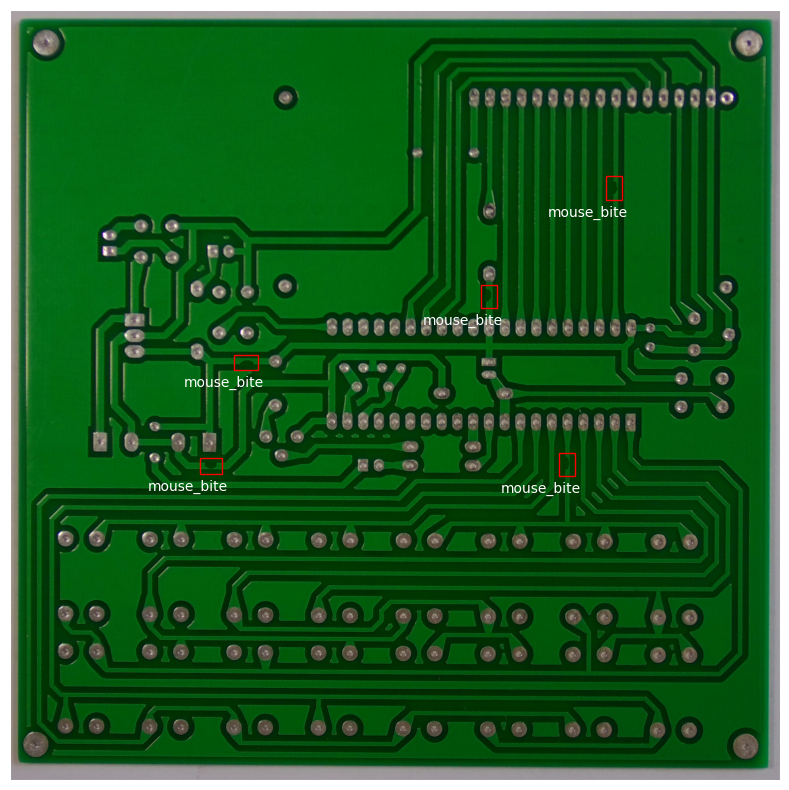

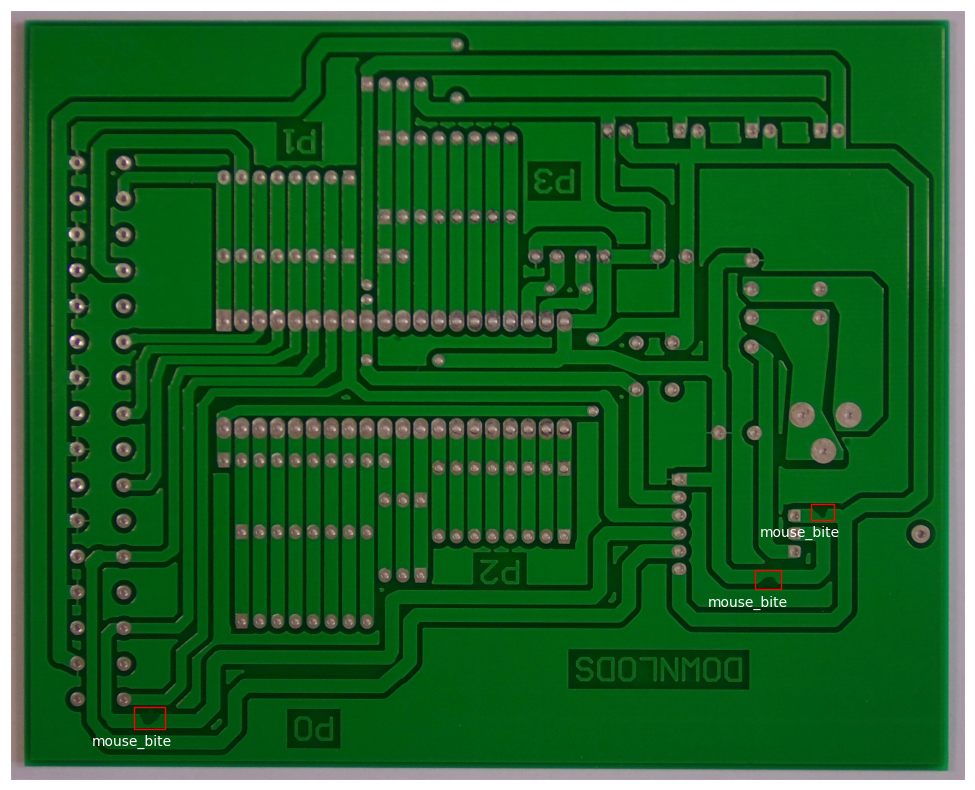

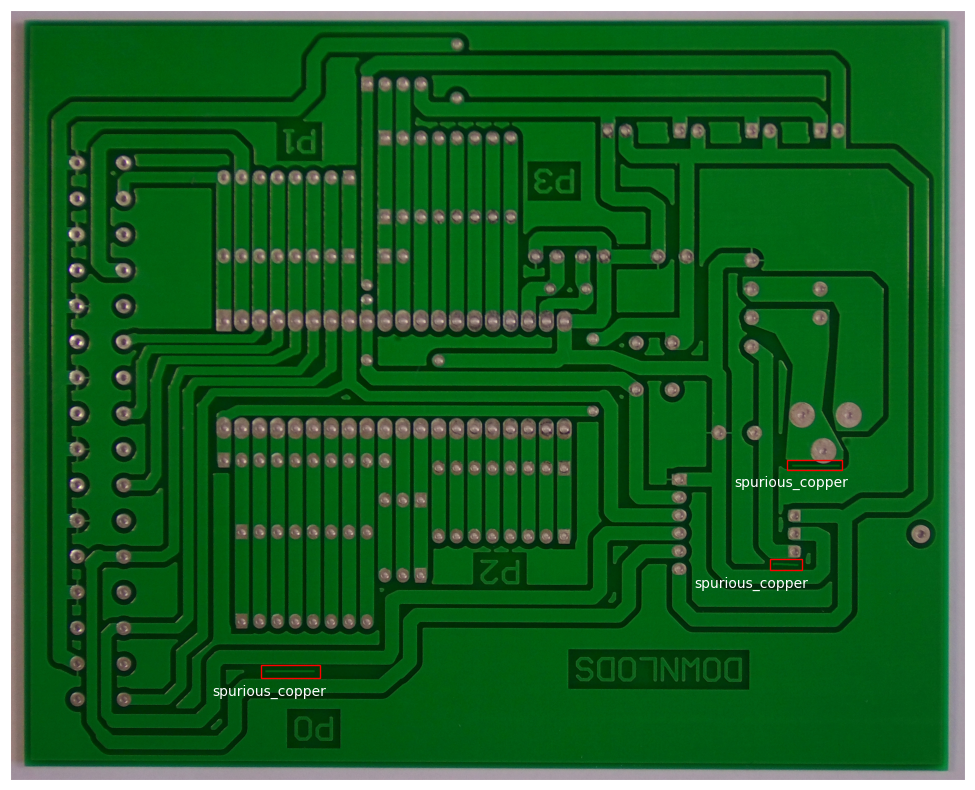

In [ ]:
random.shuffle(img_path_list)

visualize_annotations(img_path_list[0:5],df_annot)

In [ ]:
#To create a folder for the cropped patches

# def crop_patches_with_margin(image_path, bounding_boxes, annotations, out_dir, margin=20):
#     """

#     Args:
#         image_path: Path to the original image.
#         bounding_boxes: List of bounding boxes (xmin, ymin, xmax, ymax).
#         annotations: List of class names corresponding to each bounding box.
#         out_dir: Root directory to save cropped patches.
#         margin: Extra pixels to include around each bounding box.
#     """
#     img = cv2.imread(image_path)
#     h, w = img.shape[:2]

#     filename = re.sub(r'.+/([\w_]+\.jpg)', r'\1', image_path)
#     base_name = os.path.splitext(filename)[0]

#     for idx, (bbox, annotation) in enumerate(zip(bounding_boxes, annotations)):
#         xmin, ymin, xmax, ymax = bbox

#         # Expand bounding box with margin
#         xmin = max(0, xmin - margin)
#         ymin = max(0, ymin - margin)
#         xmax = min(w, xmax + margin)
#         ymax = min(h, ymax + margin)

#         # Crop patch
#         patch = img[ymin:ymax, xmin:xmax]

#         # Create class-specific folder
#         class_dir = os.path.join(out_dir, annotation)
#         os.makedirs(class_dir, exist_ok=True)

#         # Save patch
#         patch_filename = f"{base_name}_{annotation}_{idx}.jpg"
#         save_path = os.path.join(class_dir, patch_filename)
#         cv2.imwrite(save_path, patch)


# def save_all_patches_with_margin(list_image_path, df, out_dir="/content/drive/MyDrive/PCB_DATASET/patches", margin=20):
#     os.makedirs(out_dir, exist_ok=True)

#     for filepath in list_image_path:
#         filename = re.sub(r'.+/([\w_]+\.jpg)', r'\1', filepath)
#         df_selected = df[df['filename'] == filename]

#         xmin = df_selected['xmin'].values
#         ymin = df_selected['ymin'].values
#         xmax = df_selected['xmax'].values
#         ymax = df_selected['ymax'].values
#         class_name = df_selected['class'].values

#         bbox = list(zip(xmin, ymin, xmax, ymax))

#         crop_patches_with_margin(filepath, bbox, class_name, out_dir, margin)

# save_all_patches_with_margin(img_path_list, df_annot, margin=40)

In [ ]:
# Basic configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Update the img_dir variable to the path
img_dir = '/content/drive/MyDrive/PCB_DATASET/patches'
print(f"img_dir: {img_dir}")

# 2. Initialize an empty list
new_all_data = []

# Get a list of all subdirectoriesin the img_dir
class_names_in_patches = [d for d in os.listdir(img_dir) if os.path.isdir(os.path.join(img_dir, d))]

# 3. Iterate through each item in the new img_dir
for class_name_patch in class_names_in_patches:
    class_path = os.path.join(img_dir, class_name_patch)
    # 4. For each class_name, iterate through the files within its corresponding subdirectory
    for file in os.listdir(class_path):
        # Ensure it's a file and not a directory
        if os.path.isfile(os.path.join(class_path, file)):
            # 5. Construct the full image_path
            image_path = os.path.join(class_path, file)
            # 6. Append a dictionary containing 'image_path' and 'class_name' to the new_all_data list
            new_all_data.append({'image_path': image_path, 'class_name': class_name_patch})

# 7. Create a new Pandas DataFrame, df_patches, from the new_all_data list
df_patches = pd.DataFrame(new_all_data)
print(f"Successfully created df_patches with {len(df_patches)} entries.")

# Get the list of classes and number of classes from the new df_patches (from cell 34a63abf)
class_names = sorted(df_patches['class_name'].unique())
num_classes = len(class_names)
print(f"{num_classes} classes detected in the df_patches: {class_names}")


Using device: cpu
img_dir: /content/drive/MyDrive/PCB_DATASET/patches
Successfully created df_patches with 2953 entries.
6 classes detected in the df_patches: ['missing_hole', 'mouse_bite', 'open_circuit', 'short', 'spur', 'spurious_copper']


Train, Validation and Test

---



In [ ]:
# Split all patches directly into train, validation, and test
train_val_df_patches, test_df_patches = train_test_split(df_patches, test_size=0.15, random_state=42, stratify=df_patches['class_name'])
train_df_patches, val_df_patches = train_test_split(train_val_df_patches, test_size=0.15, random_state=42, stratify=train_val_df_patches['class_name'])

# Reset indices for clean dataframes
train_df_patches = train_df_patches.reset_index(drop=True)
val_df_patches = val_df_patches.reset_index(drop=True)
test_df_patches = test_df_patches.reset_index(drop=True)

# Update dataset_sizes dictionary
dataset_sizes = {
    'train': len(train_df_patches),
    'val': len(val_df_patches),
    'test': len(test_df_patches)
}
print(f"Number of patches - Train: {dataset_sizes['train']}, Validation: {dataset_sizes['val']}, Test: {dataset_sizes['test']}")

# Data Augmentation and Normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(25),
        transforms.ColorJitter(
            brightness=0.3,
            contrast=0.3,
            saturation=0.3,
            hue=0.1
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]
        )
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Custom Dataset class for directly loading pre-cropped images
class PatchesDataset(Dataset):
    def __init__(self, dataframe, class_names, transform=None):
        self.df = dataframe
        self.transform = transform
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(class_names)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['image_path']
        label_idx = self.class_to_idx[row['class_name']]

        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            print(f"Warning: File not found {img_path}. Returning an empty tensor.")
            return torch.zeros((3, 224, 224)), -1  # Handle missing file case

        if self.transform:
            image = self.transform(image)

        return image, label_idx

# Create datasets and dataloaders for the patched data
train_dataset_patches = PatchesDataset(train_df_patches, class_names, transform=data_transforms['train'])
val_dataset_patches = PatchesDataset(val_df_patches, class_names, transform=data_transforms['val'])
test_dataset_patches = PatchesDataset(test_df_patches, class_names, transform=data_transforms['val'])

# Use a smaller batch size initially to avoid memory issues
batch_size = 16

dataloaders_patches = {
    'train': DataLoader(train_dataset_patches, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count()),
    'val': DataLoader(val_dataset_patches, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count()),
    'test': DataLoader(test_dataset_patches, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())
}

Number of patches - Train: 2133, Validation: 377, Test: 443


**PRETRAINED MODEL**

In [ ]:
def get_pretrained_model(num_classes):
    # Load the model with pre-trained weights
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    for name, param in model.named_parameters():
        if "layer4" in name or "fc" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    # Replace the final layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    return model.to(device)

**TRAINING AND VALIDATION FUNCTION**

In [ ]:
def train_model(model, criterion, optimizer, dataloaders_arg, dataset_sizes_arg, num_epochs=50, patience=5):
    since = time.time()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}' + ' | ' + '-'*10)
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss, running_corrects = 0.0, 0

            for inputs, labels in dataloaders_arg[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward(); optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes_arg[phase]
            epoch_acc = running_corrects.double() / dataset_sizes_arg[phase]
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            if phase == 'val':
                if epoch_loss < best_loss:
                    print(f"Validation loss improved ({best_loss:.4f} -> {epoch_loss:.4f}). Saving model...")
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after {patience} epochs with no improvement.")
            break
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best Validation Loss: {best_loss:4f}')

    model.load_state_dict(best_model_wts)
    return model, history


In [ ]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

resnet_model_patches = get_pretrained_model(num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
# Optimize only parameters of the new layer (those that are not frozen)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet_model_patches.parameters()), lr=0.001)

print("Starting training")
# Start training with the dataloaders_patches
best_resnet_model_patches, history_patches = train_model(
    resnet_model_patches, criterion, optimizer, dataloaders_patches, dataset_sizes, num_epochs=50, patience=5
)
print("Training complete")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 120MB/s]


Starting training
Epoch 1/50 | ----------
Train Loss: 0.5271 Acc: 0.8298
Val Loss: 0.1975 Acc: 0.9416
Validation loss improved (inf -> 0.1975). Saving model...

Epoch 2/50 | ----------
Train Loss: 0.1648 Acc: 0.9503
Val Loss: 0.1440 Acc: 0.9443
Validation loss improved (0.1975 -> 0.1440). Saving model...

Epoch 3/50 | ----------
Train Loss: 0.1008 Acc: 0.9705
Val Loss: 0.1028 Acc: 0.9814
Validation loss improved (0.1440 -> 0.1028). Saving model...

Epoch 4/50 | ----------
Train Loss: 0.0860 Acc: 0.9747
Val Loss: 0.0454 Acc: 0.9814
Validation loss improved (0.1028 -> 0.0454). Saving model...

Epoch 5/50 | ----------
Train Loss: 0.0689 Acc: 0.9775
Val Loss: 0.0631 Acc: 0.9788

Epoch 6/50 | ----------
Train Loss: 0.0549 Acc: 0.9831
Val Loss: 0.0451 Acc: 0.9788
Validation loss improved (0.0454 -> 0.0451). Saving model...

Epoch 7/50 | ----------
Train Loss: 0.0441 Acc: 0.9850
Val Loss: 0.0596 Acc: 0.9814

Epoch 8/50 | ----------
Train Loss: 0.0241 Acc: 0.9920
Val Loss: 0.0196 Acc: 0.9973
V

**RESULT ANALYSIS AND EVALUATION**

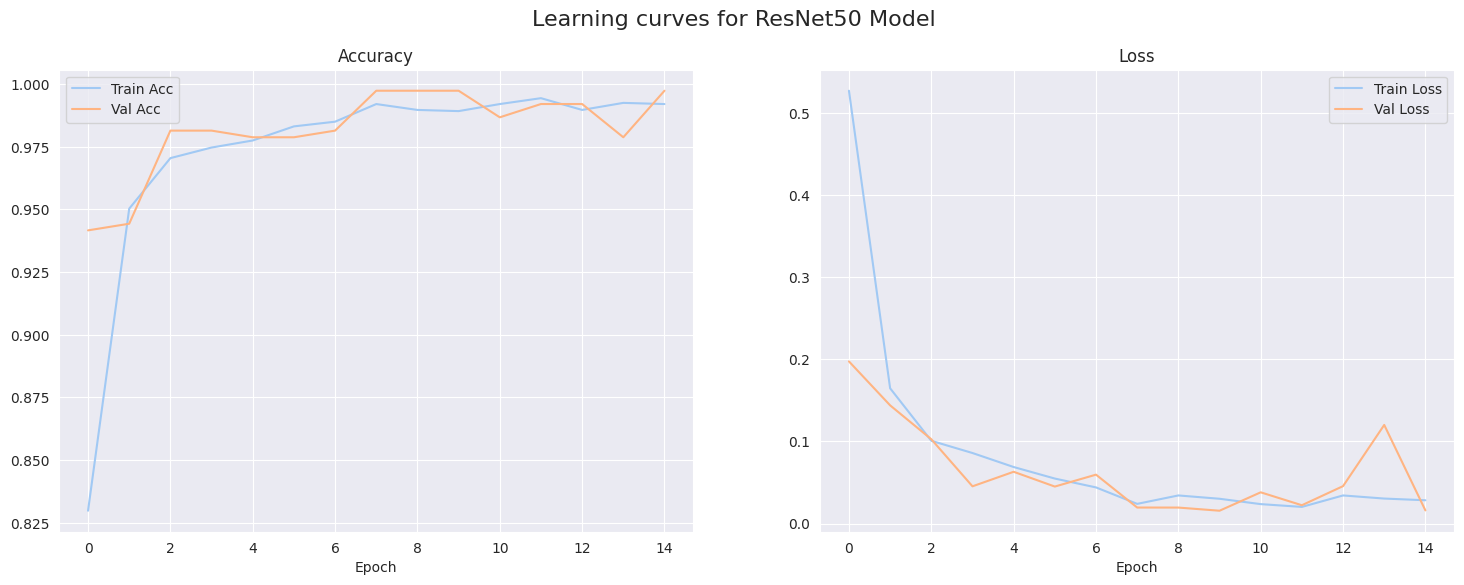


--- Final evaluation of model 'ResNet50_Patches' on the Test set ---

                 precision    recall  f1-score   support

   missing_hole     1.0000    1.0000    1.0000        75
     mouse_bite     1.0000    0.9865    0.9932        74
   open_circuit     1.0000    1.0000    1.0000        72
          short     1.0000    1.0000    1.0000        74
           spur     0.9865    1.0000    0.9932        73
spurious_copper     1.0000    1.0000    1.0000        75

       accuracy                         0.9977       443
      macro avg     0.9977    0.9977    0.9977       443
   weighted avg     0.9978    0.9977    0.9977       443



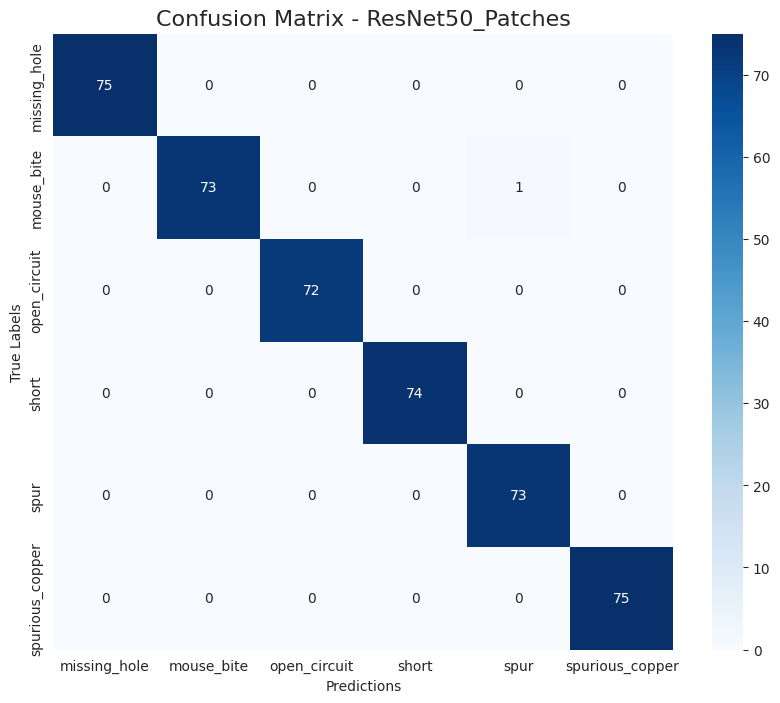

In [ ]:
def plot_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle(f"Learning curves for {model_name}", fontsize=16)
    ax1.plot(history['train_acc'], label='Train Acc'); ax1.plot(history['val_acc'], label='Val Acc')
    ax1.set_title('Accuracy'); ax1.set_xlabel('Epoch'); ax1.legend(); ax1.grid(True)
    ax2.plot(history['train_loss'], label='Train Loss'); ax2.plot(history['val_loss'], label='Val Loss')
    ax2.set_title('Loss'); ax2.set_xlabel('Epoch'); ax2.legend(); ax2.grid(True)
    plt.show()

# Evaluation on the test set
def evaluate_model(model, dataloader, model_name, class_names):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs.to(device))
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.cpu().numpy())

    print(f"\n--- Final evaluation of model '{model_name}' on the Test set ---\n")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16)
    plt.xlabel('Predictions'); plt.ylabel('True Labels')
    plt.show()


# Plot learning curves
plot_history(history_patches, "ResNet50 Model")

# Evaluate on the test set
evaluate_model(best_resnet_model_patches, dataloaders_patches['test'], "ResNet50_Patches", class_names)

In [ ]:
# Save the model
MODEL_PATH_PATCHES = "/content/drive/MyDrive/Colab Notebooks/best_resnet50_pcb_defects_50epochs_patches_1.pth"
torch.save(
    {
        "model_state_dict": best_resnet_model_patches.state_dict(),
        "class_names": class_names,
    }, MODEL_PATH_PATCHES
)

print(f"Model saved to {MODEL_PATH_PATCHES}")

Model saved to /content/drive/MyDrive/Colab Notebooks/best_resnet50_pcb_defects_50epochs_patches_1.pth
